In [1]:
from datetime import datetime
import json
from collections import Counter

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from deeprec.torch.trainer import Trainer, set_device
from deeprec import ROOT

In [2]:
with open('../data/metadata.json', 'r') as fp:
    meta = json.load(fp)

meta.keys()

dict_keys(['title_emb_size', 'string_na', 'genres', 'ages', 'occupations', 'user', 'movie', 'city', 'state'])

In [3]:
class Vocab(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x):
        c = Counter(x)
        self.lookup_ = {
            str(v).lower(): k for k, v in enumerate([x[0] for x in sorted(c.items(), key=lambda x: x[1], reverse=True)])
        }

    def transform(self, x):
        return [self.lookup_.get(str(xx).lower(), len(self.lookup_)+1) for xx in x]

In [4]:
df = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
df.head()

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
693094,1489,2648,3,5,11,2000-11-25 03:35:14,1,35,2,Evanston,...,0.059832,0.46583,0.774960,0.43321,0.370830,0.140020,0.521110,-0.960430,-0.622770,0.245130
563664,2440,3101,17,1,11,2000-11-14 17:03:49,0,50,17,Ashburnham,...,1.982520,0.84989,1.708770,1.34452,-1.051670,-0.032240,0.662540,-0.448420,-1.197040,-0.698660
192,682,1193,16,3,11,2000-11-30 16:33:10,0,25,4,Carrboro,...,2.176160,2.86298,2.238394,-2.15952,1.210480,-3.436165,-0.329595,3.619880,-2.470530,1.399963
664671,3512,1005,17,0,8,2000-08-28 17:16:19,0,18,17,Cambridge,...,-1.662040,0.99335,-1.184181,1.58626,0.718946,-1.731300,2.357530,1.096584,-2.896070,0.150750
967203,5074,1202,5,5,7,2000-07-01 05:14:36,0,1,0,Purcellville,...,1.998510,1.07155,-0.863230,0.24211,-0.773756,0.235041,1.170840,-2.078201,-1.310696,-0.964250


In [5]:
state_enc = Vocab()
state_enc.fit(df['state'])

user_enc = Vocab()
user_enc.fit(df['user'])

movie_enc = Vocab()
movie_enc.fit(df['movie'])

In [6]:
df = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])
df.head()

,rating
index,
693094,3
563664,4
192,5
664671,3
967203,5


In [7]:
set(df['rating'])

{1, 2, 3, 4, 5}

In [8]:
class MovieDataset(Dataset):
    def __init__(self, filename, vocabs):
        data = pd.read_parquet(filename, columns=['user', 'movie', 'rating'])
        data['user'] = vocabs['user'].transform(data['user'])
        data['movie'] = vocabs['movie'].transform(data['movie'])

        self.feature_names = data.columns[:-1]
        self.data = data.to_dict('records')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [9]:
def collator(batch):
    inputs = {}
    elems = [k for k in batch[0].keys() if k != 'rating']
    for e in elems:
        inputs[e] = torch.tensor([x[e] for x in batch]).unsqueeze(-1)
    labels = torch.tensor([x['rating'] for x in batch], dtype=torch.float32).unsqueeze(-1)
    return inputs, labels

In [10]:
encoders = {
    'user': user_enc,
    'movie': movie_enc,
    'state': state_enc
}

train = MovieDataset('../data/train.parq.gzip', vocabs=encoders)
test = MovieDataset('../data/test.parq.gzip', vocabs=encoders)

In [11]:
dl = DataLoader(train, 4, collate_fn=collator)
next(iter(dl))


({'user': tensor([[ 406],
          [5675],
          [3393],
          [ 579]]),
  'movie': tensor([[ 779],
          [ 309],
          [  42],
          [1741]])},
 tensor([[3.],
         [4.],
         [5.],
         [3.]]))

In [12]:
class RecModel(nn.Module):
    def __init__(self, metadata, n_features=54):
        super().__init__()
        self.meta = metadata
        self.embed_dims = {
            'large': 32,
            'med': 16,
            'small': 8,
        }
        self.loss_func = nn.MSELoss()

        self.user_embeds = nn.Embedding(
            num_embeddings=len(user_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.movie_embeds = nn.Embedding(
            num_embeddings=len(movie_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.model = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        user_block = self.user_embeds(x['user'])
        movie_block = self.movie_embeds(x['movie'])
        # print(user_block.shape)
        # print(movie_block.shape)
        # print(torch.concat((user_block, movie_block), dim=-1).shape)
        x = self.model(torch.concat((user_block, movie_block), dim=-1))
        return x.squeeze(-1)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self(x)

In [13]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
MODEL_NAME = 'simple-collab-filter'
LOG_DIR = ROOT.joinpath('runs', MODEL_NAME, NOW)
BATCH = 2500
EPOCHS = 15

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True, collate_fn=collator)
test_loader = DataLoader(test, batch_size=BATCH, collate_fn=collator)

device = set_device()
mod = RecModel(metadata=meta)
opt = torch.optim.AdamW(mod.parameters(), lr=1e-2)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=.5)

trainer = Trainer(
    mod, epochs=EPOCHS, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': torchmetrics.MeanSquaredError()}, lr_schedule=sch
)
trainer.fit(train_loader, test_loader, verbose=True)

Batch: 100%|█████████▉| 360/361 [00:04<00:00, 113.67it/s]
                                                         
Epoch:   7%|▋         | 1/15 [00:04<01:02,  4.44s/it]  

defaultdict(<class 'list'>, {'epoch': [0], 'train_loss': [1.152583597274368], 'train_mse': [1.101536512374878], 'valid_loss': [0.8724039880240836], 'valid_mse': [0.8638210296630859]})



Batch:  99%|█████████▊| 356/361 [00:04<00:00, 55.03it/s]
                                                        
Epoch:  13%|█▎        | 2/15 [00:09<01:02,  4.83s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1], 'train_loss': [1.152583597274368, 0.8400773156712921], 'train_mse': [1.101536512374878, 0.8255999088287354], 'valid_loss': [0.8724039880240836, 0.8652600079047971], 'valid_mse': [0.8638210296630859, 0.8509705066680908]})



Batch:  99%|█████████▉| 359/361 [00:03<00:00, 106.22it/s]
                                                         
Epoch:  20%|██        | 3/15 [00:13<00:54,  4.53s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631]})



Batch:  99%|█████████▉| 359/361 [00:04<00:00, 79.68it/s]
                                                        
Epoch:  27%|██▋       | 4/15 [00:18<00:52,  4.76s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636]})



Batch: 100%|█████████▉| 360/361 [00:04<00:00, 77.61it/s]
                                                        
Epoch:  33%|███▎      | 5/15 [00:23<00:47,  4.72s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022]})



Batch: 100%|█████████▉| 360/361 [00:04<00:00, 116.68it/s]
                                                         
Epoch:  40%|████      | 6/15 [00:27<00:41,  4.56s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022, 0.8271316885948181]})



Batch: 100%|██████████| 361/361 [00:05<00:00, 60.79it/s]
                                                        
Epoch:  47%|████▋     | 7/15 [00:32<00:38,  4.76s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022, 0.8271316885948181, 0.8274190425872803]})



Batch:  97%|█████████▋| 350/361 [00:03<00:00, 118.84it/s]
                                                         
Epoch:  53%|█████▎    | 8/15 [00:36<00:31,  4.53s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022, 0.8271316885948181, 0.8274190425872803, 0.8259716033935547]})



Batch:  99%|█████████▉| 357/361 [00:05<00:00, 99.85it/s]
                                                        
Epoch:  60%|██████    | 9/15 [00:42<00:28,  4.79s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653, 0.7423741401397621], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635, 0.733666718006134], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123, 0.839277751562072], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022, 0.8271316885948181, 0.8274190425872803, 0.8259716033935547, 0.8284040689468384]})



Batch:  98%|█████████▊| 355/361 [00:04<00:00, 82.60it/s]
                                                        
Epoch:  67%|██████▋   | 10/15 [00:46<00:23,  4.72s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653, 0.7423741401397621, 0.7342179703250156], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635, 0.733666718006134, 0.7245464324951172], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123, 0.839277751562072, 0.8424401152424696], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022, 0.8271316885948181, 0.8274190425872803, 0.8259716033935547, 0.8284040689468384, 0.830801248550415]})



Batch:  98%|█████████▊| 355/361 [00:04<00:00, 81.11it/s]
                                                        
Epoch:  73%|███████▎  | 11/15 [00:51<00:18,  4.68s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653, 0.7423741401397621, 0.7342179703250156, 0.7123301730922055], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635, 0.733666718006134, 0.7245464324951172, 0.7073403596878052], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123, 0.839277751562072, 0.8424401152424696, 0.8304322042116304], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022, 0.8271316885948181, 0.8274190425872803, 0.8259716033935547, 0.8284040689468384, 0.830801248550415, 0.82195645


Batch: 100%|█████████▉| 360/361 [00:04<00:00, 96.05it/s]
                                                        
Epoch:  80%|████████  | 12/15 [00:56<00:14,  4.77s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653, 0.7423741401397621, 0.7342179703250156, 0.7123301730922055, 0.7048408075382835], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635, 0.733666718006134, 0.7245464324951172, 0.7073403596878052, 0.69957435131073], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123, 0.839277751562072, 0.8424401152424696, 0.8304322042116304, 0.8287532198719862], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8411288857460022, 0.8271316885948181, 0.8274190425872803, 0.82597


Batch: 100%|█████████▉| 360/361 [00:03<00:00, 119.56it/s]
                                                         
Epoch:  87%|████████▋ | 13/15 [01:00<00:08,  4.43s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653, 0.7423741401397621, 0.7342179703250156, 0.7123301730922055, 0.7048408075382835, 0.6987831323430809], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635, 0.733666718006134, 0.7245464324951172, 0.7073403596878052, 0.69957435131073, 0.6933744549751282], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123, 0.839277751562072, 0.8424401152424696, 0.8304322042116304, 0.8287532198719862, 0.8338614338781776], 'valid_mse': [0.8638210296630859, 0.8509705066680908, 0.8450561165809631, 0.8413580656051636, 0.8


Batch: 100%|█████████▉| 360/361 [00:04<00:00, 96.87it/s]
                                                        
Epoch:  93%|█████████▎| 14/15 [01:05<00:04,  4.59s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653, 0.7423741401397621, 0.7342179703250156, 0.7123301730922055, 0.7048408075382835, 0.6987831323430809, 0.6926835096774009], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635, 0.733666718006134, 0.7245464324951172, 0.7073403596878052, 0.69957435131073, 0.6933744549751282, 0.6869941353797913], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123, 0.839277751562072, 0.8424401152424696, 0.8304322042116304, 0.8287532198719862, 0.8338614338781776, 0.8328523010742374], 'valid_mse': [0.8638210296630859,


Batch:  98%|█████████▊| 353/361 [00:03<00:00, 113.56it/s]
                                                         
Epoch: 100%|██████████| 15/15 [01:09<00:00,  4.60s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'train_loss': [1.152583597274368, 0.8400773156712921, 0.8205656389450433, 0.8069839929939967, 0.7948228812613976, 0.7663382787123281, 0.7570240258179873, 0.7503521330138653, 0.7423741401397621, 0.7342179703250156, 0.7123301730922055, 0.7048408075382835, 0.6987831323430809, 0.6926835096774009, 0.6867210434084123], 'train_mse': [1.101536512374878, 0.8255999088287354, 0.8064792156219482, 0.7929696440696716, 0.7804115414619446, 0.7590036988258362, 0.7491777539253235, 0.7415125370025635, 0.733666718006134, 0.7245464324951172, 0.7073403596878052, 0.69957435131073, 0.6933744549751282, 0.6869941353797913, 0.6807057857513428], 'valid_loss': [0.8724039880240836, 0.8652600079047971, 0.8585293031320339, 0.8535172793923355, 0.8534056893209132, 0.8366371422279172, 0.8390225622712112, 0.8358405406882123, 0.839277751562072, 0.8424401152424696, 0.8304322042116304, 0.8287532198719862, 0.8338614338781776, 0.83285230

In [100]:
print(f'Saved model located at: {LOG_DIR}')

Saved model located at: /Users/christophersantiago/Dropbox/Programming/liveProject_deepRecommender/runs/simple-collab-filter/20220919-1309


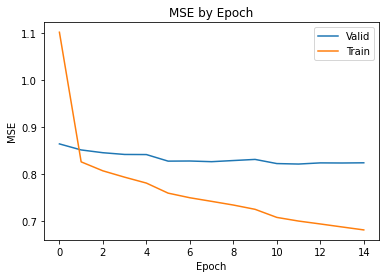

In [14]:
import matplotlib.pyplot as plt

plt.plot(trainer.results['valid_mse'], label='Valid')
plt.plot(trainer.results['train_mse'], label='Train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE by Epoch')
plt.show()

In [15]:
{e:v for e,v in enumerate(torch.sqrt(torch.tensor(trainer.results['valid_mse'])))}

{0: tensor(0.9294),
 1: tensor(0.9225),
 2: tensor(0.9193),
 3: tensor(0.9173),
 4: tensor(0.9171),
 5: tensor(0.9095),
 6: tensor(0.9096),
 7: tensor(0.9088),
 8: tensor(0.9102),
 9: tensor(0.9115),
 10: tensor(0.9066),
 11: tensor(0.9061),
 12: tensor(0.9074),
 13: tensor(0.9073),
 14: tensor(0.9075)}

<hr>

# DEBUGGING

In [63]:
x = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
y = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])

In [51]:
user = 1489
movies = [int(x) for x in list(meta['movie'].keys())[0:10]]

encoded_user = torch.tensor(user_enc.transform([user])).unsqueeze(-1)
# movies = torch.tensor(movie_enc.transform([2858]))
encoded_movies = torch.tensor(movie_enc.transform(movies)).unsqueeze(-1)

# broadcasts user dim to match movies via .expand()
preds = mod.predict({'user': encoded_user.expand(encoded_movies.shape[-2], -1),'movie': encoded_movies})
preds

tensor([[3.6816],
        [3.2422],
        [3.2360],
        [2.4695],
        [2.1667],
        [2.8036],
        [2.6297],
        [3.0097],
        [2.7558],
        [3.5934]])

In [102]:
results = pd.DataFrame({'movie': movies, 'pred_rating': preds.numpy().flatten()})
results

,movie,pred_rating
0,2858,3.681648
1,260,3.242206
2,1196,3.235992
3,1210,2.469539
4,480,2.166659
5,2028,2.803551
6,589,2.629738
7,2571,3.009728
8,1270,2.755754
9,593,3.593350


In [103]:
user_mask = (x['user'] == user) & x['movie'].isin(movies)
df_user = x.loc[user_mask]

df_user

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
102718,1489,589,20,0,11,2000-11-20 20:45:56,1,35,2,Evanston,...,0.396910,0.143238,1.457050,0.89631,0.555875,-1.050984,0.439608,-0.394870,0.262000,-0.055144
141055,1489,2571,20,0,11,2000-11-20 20:24:25,1,35,2,Evanston,...,-0.119660,0.814860,0.704639,0.56349,0.777620,-1.204130,-0.247860,0.100980,-1.281000,-0.359768
47479,1489,260,20,0,11,2000-11-20 20:21:52,1,35,2,Evanston,...,0.759896,1.180367,1.088754,-2.49483,1.888920,-3.611867,-0.968673,-0.477968,-2.449346,0.925348
117260,1489,480,20,0,11,2000-11-20 20:25:13,1,35,2,Evanston,...,-0.187000,0.335541,0.460427,-0.20839,0.745540,-0.621420,0.607130,-0.357409,-2.273740,1.774750
71443,1489,1210,20,0,11,2000-11-20 20:46:17,1,35,2,Evanston,...,1.930435,1.984775,3.203664,-2.36986,0.856150,-5.089112,2.447014,-1.729150,-3.658910,2.566328
23863,1489,1270,20,0,11,2000-11-20 20:45:56,1,35,2,Evanston,...,-1.043880,0.006530,-2.255220,-0.88403,-1.421790,-1.366555,-0.770560,1.041650,-0.876050,-1.741870
129084,1489,1196,19,0,11,2000-11-20 19:59:46,1,35,2,Evanston,...,-0.160883,-1.184947,0.796664,-2.08923,2.708920,-5.271990,-0.341982,2.108941,-5.036370,1.916858
107909,1489,2858,22,0,11,2000-11-20 22:20:36,1,35,2,Evanston,...,-0.250560,0.730900,0.378270,0.77064,1.262100,-1.366550,0.106610,-1.792140,-1.323940,0.102870


In [104]:
y.loc[user_mask]

,rating
index,
102718,4
141055,3
47479,3
117260,2
71443,3
23863,2
129084,3
107909,3


In [105]:
actual_ratings = dict(zip(df_user['movie'], y.loc[user_mask]['rating']))
actual_ratings

{589: 4, 2571: 3, 260: 3, 480: 2, 1210: 3, 1270: 2, 1196: 3, 2858: 3}

In [106]:
results['actual_rating'] = results['movie'].map(actual_ratings)
results

,movie,pred_rating,actual_rating
0,2858,3.681648,3.0
1,260,3.242206,3.0
2,1196,3.235992,3.0
3,1210,2.469539,3.0
4,480,2.166659,2.0
5,2028,2.803551,NaN
6,589,2.629738,4.0
7,2571,3.009728,3.0
8,1270,2.755754,2.0
9,593,3.593350,NaN


In [107]:
movie_titles = pd.read_parquet('../data/dataset.parq.gzip', columns=['movie', 'title']).drop_duplicates()
movie2_title = dict(zip(movie_titles['movie'], movie_titles['title']))

In [108]:
results['title'] = results['movie'].map(movie2_title)
results

,movie,pred_rating,actual_rating,title
0,2858,3.681648,3.0,American Beauty
1,260,3.242206,3.0,Star Wars: Episode IV - A New Hope
2,1196,3.235992,3.0,Star Wars: Episode V - The Empire Strikes Back
3,1210,2.469539,3.0,Star Wars: Episode VI - Return of the Jedi
4,480,2.166659,2.0,Jurassic Park
5,2028,2.803551,NaN,Saving Private Ryan
6,589,2.629738,4.0,Terminator 2: Judgment Day
7,2571,3.009728,3.0,"Matrix, The"
8,1270,2.755754,2.0,Back to the Future
9,593,3.593350,NaN,"Silence of the Lambs, The"
